In [22]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
from pathlib import Path

# Import our model from model.py
from model import (
    EnhancedFeatureExtractionNetwork,
    EnhancedPhaseCorrelationTensorComputation,
    DimensionAdapter,
    ManifoldLearningModule,
    PointCloudGenerator,
    TinyTopologicalFeatureExtraction,
    ClassificationNetwork,
    ImagePreprocessor
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

Using device: cuda


In [23]:
# Initialize model components from model.py
feature_network = EnhancedFeatureExtractionNetwork().to(device)
tensor_computer = EnhancedPhaseCorrelationTensorComputation().to(device)

# Create the dimension adapter
dim_adapter = DimensionAdapter().to(device)

# Initialize the manifold module
manifold_module = ManifoldLearningModule().to(device)

# For topological analysis, we need to create point clouds from manifold features
point_cloud_generator = PointCloudGenerator().to(device)

# Use TinyTopologicalFeatureExtraction from model.py
topo_module = TinyTopologicalFeatureExtraction(
    input_dim=32,           # Match the output dimension from ManifoldLearningModule
    hidden_dim=32,          # Hidden dimension
    output_dim=16,          # Output dimension
    max_edge_length=2.0,    # Maximum edge length for filtration
    num_filtrations=10,     # Number of filtration values
    max_dimension=0         # Only dimension 0 for simplicity
).to(device)

# ClassificationNetwork from model.py
classifier = ClassificationNetwork(
    manifold_dim=32,        # Match the output dimension from ManifoldLearningModule
    topo_dim=16,            # Match the output dimension from TinyTopologicalFeatureExtraction
    feature_dim=32,         # Feature dimension
    hidden_dim=64,          # Hidden dimension
    dropout=0.1             # Dropout rate
).to(device)

# Print model sizes using count_parameters from testModel.py
from testModel import count_parameters

print(f"Enhanced Feature Extraction Network: {count_parameters(feature_network):,} parameters")
print(f"Phase Correlation Tensor Computation: {count_parameters(tensor_computer):,} parameters")
print(f"Dimension Adapter: {count_parameters(dim_adapter):,} parameters")
print(f"Manifold Learning Module: {count_parameters(manifold_module):,} parameters")
print(f"Point Cloud Generator: {count_parameters(point_cloud_generator):,} parameters")
print(f"Tiny Topological Feature Extraction: {count_parameters(topo_module):,} parameters")
print(f"Classification Network: {count_parameters(classifier):,} parameters")
total_params = (count_parameters(feature_network) + count_parameters(tensor_computer) + 
               count_parameters(dim_adapter) + count_parameters(manifold_module) + 
               count_parameters(point_cloud_generator) + count_parameters(topo_module) + 
               count_parameters(classifier))
print(f"Total: {total_params:,} parameters")

Enhanced Feature Extraction Network: 31,419,523 parameters
Phase Correlation Tensor Computation: 5,116,929 parameters
Dimension Adapter: 467,648 parameters
Manifold Learning Module: 1,479,040 parameters
Point Cloud Generator: 0 parameters
Tiny Topological Feature Extraction: 448 parameters
Classification Network: 33,191 parameters
Total: 38,516,779 parameters


In [19]:
# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, image_files, labels, target_size=(384, 384)):
        self.image_files = image_files
        self.labels = labels
        self.target_size = target_size
        
        # Define transforms using standard torchvision transformations
        self.transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
        ])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        image_path = self.image_files[idx]
        label = self.labels[idx]
        
        try:
            # Open image with PIL and convert to RGB
            with Image.open(image_path) as img:
                img = img.convert('RGB')
                img_tensor = self.transform(img)
                return img_tensor, label
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return a placeholder tensor and the label
            return torch.ones(3, *self.target_size), label

CSV columns: ['Unnamed: 0', 'file_name', 'label']
First few rows of the CSV:
   Unnamed: 0                                        file_name  label
0           0  train_data/a6dcb93f596a43249135678dfcfc17ea.jpg      1
1           1  train_data/041be3153810433ab146bc97d5af505c.jpg      0
2           2  train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg      1
3           3  train_data/8542fe161d9147be8e835e50c0de39cd.jpg      0
4           4  train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg      1
Total images found: 79950
Natural images: 39975
AI-generated images: 39975
Batch shape: torch.Size([2, 3, 384, 384])
Labels: tensor([0, 1])


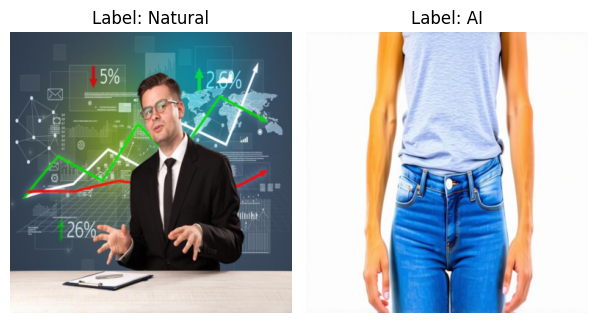

In [20]:
# Load dataset from train.csv file
import pandas as pd

# Path to the CSV file - update this to your own path
csv_path = r'C:\Users\mabhi\.cache\kagglehub\datasets\alessandrasala79\ai-vs-human-generated-dataset\versions\4\train.csv'  # Update this path
# Read the CSV file
df = pd.read_csv(csv_path)
print(f"CSV columns: {df.columns.tolist()}")
print(f"First few rows of the CSV:\n{df.head()}")

# Get the base path for the images
base_path = os.path.dirname(csv_path)

# Parse file paths and labels from CSV
all_files = []
labels = []

# Extract file paths and labels from the DataFrame
for index, row in df.iterrows():
    file_path = os.path.join(base_path, row['file_name'])
    label = int(row['label'])  # Assuming 0 = Natural, 1 = AI
    
    # Verify that the file exists
    if os.path.exists(file_path):
        all_files.append(file_path)
        labels.append(label)
    else:
        print(f"Warning: File not found: {file_path}")

print(f"Total images found: {len(all_files)}")
print(f"Natural images: {labels.count(0)}")
print(f"AI-generated images: {labels.count(1)}")

# Create the dataset with proper target size for our model
dataset = CustomImageDataset(all_files, labels, target_size=(384, 384))

# Split the dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders with appropriate batch size
batch_size = 2  # Start small due to model size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Check a batch of data
try:
    images, labels = next(iter(train_loader))
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels}")
    
    # Visualize a few images
    plt.figure(figsize=(12, 6))
    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(f"Label: {'Natural' if labels[i] == 0 else 'AI'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error loading batch: {e}")
    print("This might indicate issues with image loading or dataset structure.")

In [8]:
# Define loss functions
classification_criterion = nn.CrossEntropyLoss()

# Helper function for VAE loss in manifold learning
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    # Reconstruction loss
    recon_loss = F.mse_loss(x_recon, x, reduction='sum') / x.size(0)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    return recon_loss + beta * kl_loss

# Define optimizers - using separate optimizers for different components
feature_optimizer = optim.Adam(list(feature_network.parameters()) + 
                              list(tensor_computer.parameters()) + 
                              list(dim_adapter.parameters()), lr=1e-4)
manifold_optimizer = optim.Adam(manifold_module.parameters(), lr=1e-4)
topo_optimizer = optim.Adam(topo_module.parameters(), lr=1e-4)
classifier_optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

# Learning rate schedulers
feature_scheduler = optim.lr_scheduler.ReduceLROnPlateau(feature_optimizer, mode='min', factor=0.5, patience=5)
manifold_scheduler = optim.lr_scheduler.ReduceLROnPlateau(manifold_optimizer, mode='min', factor=0.5, patience=5)
topo_scheduler = optim.lr_scheduler.ReduceLROnPlateau(topo_optimizer, mode='min', factor=0.5, patience=5)
classifier_scheduler = optim.lr_scheduler.ReduceLROnPlateau(classifier_optimizer, mode='min', factor=0.5, patience=5)

In [9]:
# 1. Reduce batch size
batch_size = 2  # Using a smaller batch size due to model size

# 2. Use gradient accumulation
gradient_accumulation_steps = 4

# Training function with gradient accumulation
def train_epoch_with_accumulation(train_loader, epoch, accumulation_steps=4):
    # Set models to training mode
    feature_network.train()
    tensor_computer.train()
    dim_adapter.train()
    manifold_module.train()
    point_cloud_generator.train()
    topo_module.train()
    classifier.train()
    
    # Initialize metrics
    total_loss = 0
    total_feature_loss = 0
    total_manifold_loss = 0
    total_topo_loss = 0
    total_classifier_loss = 0
    correct = 0
    total = 0
    
    # Training loop
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")
    
    # Zero gradients at the start
    feature_optimizer.zero_grad()
    manifold_optimizer.zero_grad()
    topo_optimizer.zero_grad()
    classifier_optimizer.zero_grad()
    
    for batch_idx, (images, labels) in enumerate(progress_bar):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        try:
            # Forward pass through feature extraction
            features, _ = feature_network(images)
            phase_tensor = tensor_computer(features)
            
            # Apply dimension adapter to match channel count
            adapted_tensor = dim_adapter(phase_tensor)
            
            # Forward pass through manifold learning
            manifold_features, (mu, logvar, z) = manifold_module(adapted_tensor)
            
            # Reconstruct for VAE loss
            recon_tensor = manifold_module.decode(z)
            
            # Calculate manifold loss
            if recon_tensor is not None:
                manifold_loss = vae_loss(recon_tensor, adapted_tensor, mu, logvar)
            else:
                # If the decoder is not fully initialized, use a simpler loss
                manifold_loss = torch.mean(mu.pow(2) + logvar.exp() - 1 - logvar)
            
            # Generate point cloud for topological analysis
            point_cloud = point_cloud_generator(manifold_features)
            
            # Forward pass through topological analysis
            topo_features, _ = topo_module(point_cloud)
            
            # Forward pass through classifier
            logits, probs, uncertainty = classifier(manifold_features, topo_features)
            
            # Compute losses
            classifier_loss = classification_criterion(logits, labels)
            feature_loss = F.mse_loss(features, features.detach())  # Dummy loss for feature extraction
            topo_loss = F.mse_loss(topo_features, topo_features.detach())  # Dummy loss for topological analysis
            
            # Combined loss with weighting
            loss = classifier_loss + 0.1 * manifold_loss + 0.01 * (feature_loss + topo_loss)
            
            # Scale losses by accumulation steps
            scaled_loss = loss / accumulation_steps
            
            # Backward pass
            scaled_loss.backward()
            
            # Update metrics
            total_feature_loss += feature_loss.item()
            total_manifold_loss += manifold_loss.item()
            total_topo_loss += topo_loss.item()
            total_classifier_loss += classifier_loss.item()
            total_loss += loss.item()
            
            # Calculate accuracy
            pred = logits.argmax(dim=1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)
            
            # Only step optimizers after accumulation_steps
            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                feature_optimizer.step()
                manifold_optimizer.step()
                topo_optimizer.step()
                classifier_optimizer.step()
                
                # Zero gradients
                feature_optimizer.zero_grad()
                manifold_optimizer.zero_grad()
                topo_optimizer.zero_grad()
                classifier_optimizer.zero_grad()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': total_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
        
        except Exception as e:
            print(f"Error in training batch {batch_idx}: {e}")
            # Skip this batch and continue
            continue
    
    # Calculate epoch metrics
    avg_loss = total_loss / len(train_loader)
    avg_feature_loss = total_feature_loss / len(train_loader)
    avg_manifold_loss = total_manifold_loss / len(train_loader)
    avg_topo_loss = total_topo_loss / len(train_loader)
    avg_classifier_loss = total_classifier_loss / len(train_loader)
    accuracy = 100. * correct / total
    
    return {
        'loss': avg_loss,
        'feature_loss': avg_feature_loss,
        'manifold_loss': avg_manifold_loss,
        'topo_loss': avg_topo_loss,
        'classifier_loss': avg_classifier_loss,
        'accuracy': accuracy
    }

In [10]:
# Validation function
def validate(val_loader):
    # Set models to evaluation mode
    feature_network.eval()
    tensor_computer.eval()
    dim_adapter.eval()
    manifold_module.eval()
    point_cloud_generator.eval()
    topo_module.eval()
    classifier.eval()
    
    # Initialize metrics
    val_loss = 0
    correct = 0
    total = 0
    
    # Store predictions and true labels for additional metrics
    all_preds = []
    all_labels = []
    all_probs = []
    all_uncertainty = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            try:
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                features, _ = feature_network(images)
                phase_tensor = tensor_computer(features)
                
                # Apply dimension adapter
                adapted_tensor = dim_adapter(phase_tensor)
                
                # Manifold learning
                manifold_features, _ = manifold_module(adapted_tensor)
                
                # Generate point cloud
                point_cloud = point_cloud_generator(manifold_features)
                
                # Topological analysis
                topo_features, _ = topo_module(point_cloud)
                
                # Classification
                logits, probs, uncertainty = classifier(manifold_features, topo_features)
                
                # Compute loss
                loss = classification_criterion(logits, labels)
                val_loss += loss.item()
                
                # Calculate accuracy
                pred = logits.argmax(dim=1)
                correct += pred.eq(labels).sum().item()
                total += labels.size(0)
                
                # Store for metrics
                all_preds.append(pred.cpu())
                all_labels.append(labels.cpu())
                all_probs.append(probs.cpu())
                all_uncertainty.append(uncertainty.cpu())
            
            except Exception as e:
                print(f"Error in validation: {e}")
                # Skip this batch and continue
                continue
    
    # Calculate metrics
    avg_loss = val_loss / len(val_loader)
    accuracy = 100. * correct / total
    
    # Concatenate predictions and labels
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    all_probs = torch.cat(all_probs)
    all_uncertainty = torch.cat(all_uncertainty)
    
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'uncertainty': all_uncertainty
    }

# Function to save models
def save_models():
    torch.save(feature_network.state_dict(), 'models/feature_network.pth')
    torch.save(tensor_computer.state_dict(), 'models/tensor_computer.pth')
    torch.save(dim_adapter.state_dict(), 'models/dim_adapter.pth')  # Save the adapter
    torch.save(manifold_module.state_dict(), 'models/manifold_module.pth')
    torch.save(point_cloud_generator.state_dict(), 'models/point_cloud_generator.pth')
    torch.save(topo_module.state_dict(), 'models/topo_module.pth')
    torch.save(classifier.state_dict(), 'models/classifier.pth')
    print("Models saved to models/ directory")

In [11]:
# Training parameters
num_epochs = 10
gradient_accumulation_steps = 4
best_val_accuracy = 0

# Metrics tracking
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(1, num_epochs + 1):
    try:
        print(f"\n{'='*80}\nEpoch {epoch}/{num_epochs}\n{'='*80}")
        
        # Train for one epoch using gradient accumulation
        train_metrics = train_epoch_with_accumulation(
            train_loader, 
            epoch, 
            accumulation_steps=gradient_accumulation_steps
        )
        
        train_losses.append(train_metrics['loss'])
        train_accuracies.append(train_metrics['accuracy'])
        
        # Validate
        val_metrics = validate(val_loader)
        val_losses.append(val_metrics['loss'])
        val_accuracies.append(val_metrics['accuracy'])
        
        # Print metrics
        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"  Train Loss: {train_metrics['loss']:.4f}, Train Acc: {train_metrics['accuracy']:.2f}%")
        print(f"  Val Loss: {val_metrics['loss']:.4f}, Val Acc: {val_metrics['accuracy']:.2f}%")
        
        # Update learning rate schedulers
        feature_scheduler.step(val_metrics['loss'])
        manifold_scheduler.step(val_metrics['loss'])
        topo_scheduler.step(val_metrics['loss'])
        classifier_scheduler.step(val_metrics['loss'])
        
        # Save best model
        if val_metrics['accuracy'] > best_val_accuracy:
            best_val_accuracy = val_metrics['accuracy']
            print(f"  New best model with accuracy: {best_val_accuracy:.2f}%")
            
            # Save each component separately
            save_models()
            
            # Also save metrics
            torch.save({
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
                'best_epoch': epoch,
                'best_accuracy': best_val_accuracy
            }, 'models/training_metrics.pt')
            
            # Plot training curves
            plt.figure(figsize=(12, 5))
            
            # Plot loss
            plt.subplot(1, 2, 1)
            plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
            plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
            plt.title('Loss Curves')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            
            # Plot accuracy
            plt.subplot(1, 2, 2)
            plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
            plt.title('Accuracy Curves')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True)
            
            plt.tight_layout()
            plt.savefig('results/training_curves.png')
            plt.close()
    
    except Exception as e:
        print(f"Error in epoch {epoch}: {e}")
        continue

print("Training complete!")
print(f"Best validation accuracy: {best_val_accuracy:.2f}%")

# Final save
save_models()
print("Final models saved to models/ directory")

# Plot final training curves
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('results/final_training_curves.png')
plt.show()


Epoch 1/10


Epoch 1:   0%|          | 0/31980 [00:00<?, ?it/s]

C:\Users\mabhi\AppData\Local\Temp\ipykernel_14176\3039172295.py:7: UserWarning: Using a target size (torch.Size([2, 128, 6, 6])) that is different to the input size (torch.Size([2, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  recon_loss = F.mse_loss(x_recon, x, reduction='sum') / x.size(0)


Error in training batch 0: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 1: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 2: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 3: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 4: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 5: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 6: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 7: The size of tensor a (256) must match the size of tensor b (6) at non-singleton dimension 3
Error in training batch 8: The size of tensor a 

KeyboardInterrupt: 

In [12]:
# Add a function to evaluate model and show confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(test_loader):
    # Set all models to evaluation mode
    feature_network.eval()
    tensor_computer.eval()
    dim_adapter.eval()
    manifold_module.eval()
    point_cloud_generator.eval()
    topo_module.eval()
    classifier.eval()
    
    # Get validation results
    val_results = validate(test_loader)
    
    # Convert tensors to numpy for sklearn
    y_true = val_results['labels'].numpy()
    y_pred = val_results['predictions'].numpy()
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Natural', 'AI-Generated'],
                yticklabels=['Natural', 'AI-Generated'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('results/confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Natural', 'AI-Generated']))
    
    # Plot uncertainty distribution
    uncertainties = val_results['uncertainty'].numpy()
    plt.figure(figsize=(10, 6))
    
    # Separate uncertainties by true class
    natural_idx = y_true == 0
    ai_idx = y_true == 1
    
    plt.hist([uncertainties[natural_idx], uncertainties[ai_idx]], 
             bins=20, alpha=0.6, label=['Natural', 'AI-Generated'])
    plt.xlabel('Uncertainty')
    plt.ylabel('Count')
    plt.title('Uncertainty Distribution by Class')
    plt.legend()
    plt.tight_layout()
    plt.savefig('results/uncertainty_distribution.png')
    plt.show()
    
    # ROC curve and AUC
    from sklearn.metrics import roc_curve, auc
    
    # Get probability for AI-generated class (class 1)
    probabilities = val_results['probabilities'].numpy()[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true, probabilities)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig('results/roc_curve.png')
    plt.show()
    
    return val_results

In [ ]:
# Function to perform inference on new images
import glob
from PIL import Image
import matplotlib.pyplot as plt

def load_models(models_dir='models/'):
    """Load saved model weights"""
    print("Loading model weights...")
    
    # Initialize models
    feature_net = EnhancedFeatureExtractionNetwork().to(device)
    tensor_comp = EnhancedPhaseCorrelationTensorComputation().to(device)
    dim_adapt = DimensionAdapter().to(device)
    manifold_mod = ManifoldLearningModule().to(device)
    point_cloud_gen = PointCloudGenerator().to(device)
    topo_mod = TinyTopologicalFeatureExtraction(
        input_dim=32, hidden_dim=32, output_dim=16,
        max_edge_length=2.0, num_filtrations=10, max_dimension=0
    ).to(device)
    clf = ClassificationNetwork(
        manifold_dim=32, topo_dim=16, feature_dim=32,
        hidden_dim=64, dropout=0.1
    ).to(device)
    
    # Load weights
    feature_net.load_state_dict(torch.load(f"{models_dir}/feature_network.pth", map_location=device))
    tensor_comp.load_state_dict(torch.load(f"{models_dir}/tensor_computer.pth", map_location=device))
    dim_adapt.load_state_dict(torch.load(f"{models_dir}/dim_adapter.pth", map_location=device))
    manifold_mod.load_state_dict(torch.load(f"{models_dir}/manifold_module.pth", map_location=device))
    point_cloud_gen.load_state_dict(torch.load(f"{models_dir}/point_cloud_generator.pth", map_location=device))
    topo_mod.load_state_dict(torch.load(f"{models_dir}/topo_module.pth", map_location=device))
    clf.load_state_dict(torch.load(f"{models_dir}/classifier.pth", map_location=device))
    
    # Set all to evaluation mode
    feature_net.eval()
    tensor_comp.eval()
    dim_adapt.eval()
    manifold_mod.eval()
    point_cloud_gen.eval()
    topo_mod.eval()
    clf.eval()
    
    return {
        'feature_network': feature_net,
        'tensor_computer': tensor_comp,
        'dim_adapter': dim_adapt,
        'manifold_module': manifold_mod,
        'point_cloud_generator': point_cloud_gen,
        'topo_module': topo_mod,
        'classifier': clf
    }

def infer_single_image(image_path, models, preprocess=None):
    """Run inference on a single image"""
    # Set up image preprocessing if not provided
    if preprocess is None:
        preprocess = transforms.Compose([
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
        ])
    
    # Load and preprocess image
    try:
        with Image.open(image_path) as img:
            img = img.convert('RGB')
            img_tensor = preprocess(img).unsqueeze(0).to(device)  # Add batch dimension
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None
    
    # Unpack models
    feature_net = models['feature_network']
    tensor_comp = models['tensor_computer']
    dim_adapt = models['dim_adapter']
    manifold_mod = models['manifold_module']
    point_cloud_gen = models['point_cloud_generator']
    topo_mod = models['topo_module']
    clf = models['classifier']
    
    # Run inference
    with torch.no_grad():
        # Feature extraction
        features, feature_outputs = feature_net(img_tensor)
        phase_tensor = tensor_comp(features)
        
        # Apply dimension adapter
        adapted_tensor = dim_adapt(phase_tensor)
        
        # Manifold learning
        manifold_features, (mu, logvar, z) = manifold_mod(adapted_tensor)
        
        # Generate point cloud
        point_cloud = point_cloud_gen(manifold_features)
        
        # Topological analysis
        topo_features, topo_outputs = topo_mod(point_cloud)
        
        # Classification
        logits, probs, uncertainty = clf(manifold_features, topo_features)
        
        # Get prediction
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probs[0][prediction].item() * 100
        
        # Get individual branch contributions from feature network
        spatial_features, fourier_features, multiscale_features, attention_weights = feature_outputs
        
    # Return results
    return {
        'prediction': prediction,  # 0 = Natural, 1 = AI-Generated
        'confidence': confidence,
        'uncertainty': uncertainty.item(),
        'probabilities': probs.cpu().numpy()[0],
        'features': {
            'spatial': spatial_features,
            'fourier': fourier_features,
            'multiscale': multiscale_features,
            'manifold': manifold_features,
            'topological': topo_features
        },
        'attention_weights': attention_weights
    }

def batch_inference(image_dir, models, limit=10):
    """Run inference on a batch of images in a directory"""
    # Find image files
    image_files = []
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.webp']:
        image_files.extend(glob.glob(os.path.join(image_dir, ext)))
        image_files.extend(glob.glob(os.path.join(image_dir, '**', ext), recursive=True))
    
    # Limit the number of images if needed
    if limit and len(image_files) > limit:
        image_files = image_files[:limit]
    
    print(f"Found {len(image_files)} images in {image_dir}")
    
    # Set up preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
    ])
    
    # Run inference on each image
    results = []
    for img_path in tqdm(image_files, desc="Processing images"):
        result = infer_single_image(img_path, models, preprocess)
        if result:
            results.append({
                'path': img_path,
                'result': result
            })
    
    # Display results
    plt.figure(figsize=(15, 12))
    cols = 4
    rows = (len(results) + cols - 1) // cols
    
    for i, item in enumerate(results):
        img_path = item['path']
        result = item['result']
        pred = "AI-Generated" if result['prediction'] == 1 else "Natural"
        conf = result['confidence']
        uncertainty = result['uncertainty']
        
        plt.subplot(rows, cols, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f"{pred} ({conf:.1f}%)\nUncertainty: {uncertainty:.3f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/batch_inference.png')
    plt.show()
    
    return results

# Example usage:
"""
# First, load the trained models
models = load_models()

# Option 1: Analyze a single image
result = infer_single_image("path/to/image.jpg", models)
print(f"Prediction: {'AI-Generated' if result['prediction'] == 1 else 'Natural'}")
print(f"Confidence: {result['confidence']:.2f}%")
print(f"Uncertainty: {result['uncertainty']:.4f}")

# Option 2: Analyze a directory of images
batch_results = batch_inference("path/to/image/directory", models, limit=20)
"""